In [1]:
!pip install langgraph langchain langchain-openai langchain-community openai grandalf langchain_tavily

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 14.2 MB

在本期教程中，将介绍如下几点：
- 四种核心 stream_mode (values, updates, messages, custom) 的真实用法与适用场景。- 如何实现类似 ChatGPT 的打字机流式输出效果。
- 如何通过中断与恢复机制，为 Agent 加入“人工审批”功能。
- 使用 Command 和 goto 实现节点间的动态路由。
- 如何构建一个能处理多种事件的统一流式处理器。

In [2]:
# 输入环境 API Key
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')
os.environ['TAVILY_API_KEY'] = getpass.getpass('TAVILY_API_KEY:')

OpenAI API Key:··········
TAVILY_API_KEY:··········


# 第一部分: 统一的准备工作
为了避免代码重复，我们首先定义一个贯穿本文所有示例的、完整且可运行的 Agent。后续所有示例都将基于这个 app 实例或其变体。

In [3]:
import os
import asyncio
import time
from typing import Annotated,List,Generator
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode
from langgraph.config import get_stream_writer
from langchain_tavily import TavilySearch
from langchain_tavily._utilities import TavilySearchAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
import random
from langgraph.types import Command

llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0.9,
)

search_tool = TavilySearch(
    max_results=2,
    api_wrapper=TavilySearchAPIWrapper(
        tavily_api_key=os.environ.get("TAVILY_API_KEY"),
))
tools =[search_tool]

def add_messages(left: list[BaseMessage], right: list[BaseMessage])-> list[BaseMessage]:
    """将新消息列表追加到旧消息列表中"""
    return left + right

class AgentState(TypedDict):
    messages:Annotated[List[BaseMessage], add_messages]

def agent_node(state:AgentState):
    """思考节点：调用 LLM 决定下一步行动"""
    print("--- Executing node: agent_node ---")
    response = llm.bind_tools(tools).invoke(state['messages'])
    return{"messages":[response]}

tool_node =ToolNode(tools=tools)

def router(state:AgentState)-> str:
    """路由：判断是否需要调用工具"""
    print("--- Executing router ---")
    last_message = state['messages'][-1]
    if hasattr(last_message,'tool_calls') and last_message.tool_calls:
        return"tool_node"
    else:
        return"END"

graph_builder =StateGraph(AgentState)
graph_builder.add_node("agent_node", agent_node)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("agent_node")
graph_builder.add_conditional_edges(
    "agent_node",
    router,
    {
        "tool_node":"tool_node",
        "END":END
    }
)
graph_builder.add_edge("tool_node","agent_node")
app = graph_builder.compile()

# 第二部分: 四种核心 stream_mode
astream 的 stream_mode 参数决定了我们将从图的执行过程中接收到什么样的数据。让我们逐一解析这四种核心模式。
## 2.1 values 模式：获取完整状态快照
**最适合场景**：需要完整上下文进行调试，或在每一步之后将完整的状态传递给其他系统。

**工作机制**：在每个节点执行完毕后，astream 会 yield 当前 AgentState 的一个完整快照。这意味着你得到的是整个状态对象，而不仅仅是发生变化的部分。

In [4]:
async def run_values_mode():
    print("\n--- 模式: values ---")
    inputs ={"messages":[HumanMessage(content="上海天气怎么样?")]}
    async for chunk in app.astream(inputs, stream_mode="values"):
        print("--- 状态快照 ---")
        print(chunk)
        print("-"*25)
# 选择如下两种方式之一运行即可
# if __name__ == "__main__":
#     asyncio.run(run_values_mode())


# 在 notebook 里直接：
await run_values_mode()


--- 模式: values ---
--- 状态快照 ---
{'messages': [HumanMessage(content='上海天气怎么样?', additional_kwargs={}, response_metadata={})]}
-------------------------
--- Executing node: agent_node ---
--- Executing router ---
--- 状态快照 ---
{'messages': [HumanMessage(content='上海天气怎么样?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OqvqYk8I6x1r2B1M5hbt98lB', 'function': {'arguments': '{"query":"Shanghai weather","search_depth":"basic","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1272, 'total_tokens': 1298, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVf1HqBPatbND61DEyOTu4KP

## 2.2 updates 模式：获取增量更新
**最适合场景**：后端服务间的状态同步或触发逻辑。它只关心“刚刚发生了什么变化”，数据传输量最小，效率最高。

**工作机制**：astream 只 yield 在上一步中被更新或添加的状态字段。例如，如果 agent_node 只返回了 {"messages": ...}，那么你收到的 chunk 就是 {'agent_node': {'messages': ...}}，指明了更新的来源和内容。

In [5]:
async def run_updates_mode():
    print("\n--- 模式: updates ---")
    inputs ={"messages":[HumanMessage(content="上海天气怎么样?")]}
    async for chunk in app.astream(inputs, stream_mode="updates"):
        print(chunk)
        print("-"*25)
await run_updates_mode()


--- 模式: updates ---
--- Executing node: agent_node ---
--- Executing router ---
{'agent_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6m1hmgRW01j71bGVGJekH1eK', 'function': {'arguments': '{"query":"上海天气","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1272, 'total_tokens': 1293, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVf1VDq39JSOvLfIscULZ1DksOhky', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ae8bf389-e701-4edb-8be2-d246db821e12-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '上海天气', 'topic': 'news'}, 'id': 'call_6m1hmgRW01j71

## 2.3 messages 模式：构建聊天 UI 的核心
**最适合场景**：为前端提供数据流，以实现类似 ChatGPT 的打字机效果。这是实现此功能的唯一正确方式。

**工作机制**：专门用于流式传输 BaseMessage 对象。当 LLM 开始生成 token 时，astream 会持续 yieldAIMessageChunk 对象，使你能够实时地将内容渲染到 UI 上。

In [6]:
async def run_messages_mode():
    print("\n--- 模式: messages ---")
    inputs ={"messages":[HumanMessage(content="上海天气怎么样?")]}
    async for chunk in app.astream(inputs, stream_mode="messages"):
        if chunk:
            print(chunk[0].content,end="", flush=True)
            print("-"*25)
await run_messages_mode()


--- 模式: messages ---
--- Executing node: agent_node ---
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
--- Executing router ---
{"query": "上海天气", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://weather.cma.cn/web/weather/58367.html", "title": "上海 - 中国气象局-天气预报-城市预报", "content": "19℃ 16℃ 16℃ 22℃ 16℃ 15℃ 21℃ 15℃ | 气温 | 16.6℃ | 17.9℃ | 21.1℃ | 21.8℃ | 19.5℃ | 18.9℃ | 18.8℃ | 17.6℃ | | 气温 | 17.9℃ | 21.1℃ | 21.8℃ | 19.5℃ | 18.9℃ | 18.8℃ | 17.6℃ | 16.7℃ | | 气温 | 19.2℃ | 21.9℃ | 22.8℃ | 19.9℃ | 19.6℃ | 17.9℃ | 15.9℃ | 18.2℃ | | 气温 | 18.4℃ | 22.6℃ | 21.4℃ | 20.1℃ | 19.4℃ | 18.8℃ | 19.2℃ | 16.6℃ | | 气温 | 18.3℃ | 21.3℃ | 21.3℃ | 21.3℃ | 17.6℃ | 17.7℃ | 18.3℃ | 18.3℃ | | 气温 | 18.4℃ | 18.4℃ | 19.3℃ | 20.2℃ | 15.5℃ | 14.7℃ | 14.5℃ | 17.5℃ |", "score": 0.734139, "raw_content":

## 2.4 custom 模式：自定义业务事件流
**最适合场景**：向客户端传递临时的业务信号（如“正在调用API”、“思考中…”），而无需污染核心的 messages 状态。

**工作机制**：在节点内部，通过 get_stream_writer() 获取一个写入器，并使用它来写入自定义事件。这些事件会通过 custom 模式流式传输，与核心状态完全分离。

In [7]:
def agent_node_with_custom_event(state:AgentState):
    print("--- Executing node: agent_node_with_custom_event ---")
    writer = get_stream_writer()
    writer({"data":"Retrieved 0/100 records","type":"progress"})
    # 执行查询
    writer({"data":"Retrieved 100/100 records","type":"progress"})

    response = llm.bind_tools(tools).invoke(state['messages'])
    return{"messages":[response]}

# 2. 构建并编译新图
graph_custom_builder =StateGraph(AgentState)
graph_custom_builder.add_node("agent_node", agent_node_with_custom_event)
graph_custom_builder.add_node("tool_node", tool_node)
graph_custom_builder.set_entry_point("agent_node")
graph_custom_builder.add_conditional_edges(
    "agent_node",
    router,
    {
         "tool_node":"tool_node",
         "END":END
    }
)
graph_custom_builder.add_edge("tool_node","agent_node")
app_custom = graph_custom_builder.compile()

# 3. 运行并监听
async def run_custom_mode():
    print("\n--- 模式: custom ---")
    inputs ={"messages":[HumanMessage(content="上海天气怎么样?")]}
    async for chunk in app_custom.astream(inputs, stream_mode="custom"):
        print(chunk)
await run_custom_mode()


--- 模式: custom ---
--- Executing node: agent_node_with_custom_event ---
{'data': 'Retrieved 0/100 records', 'type': 'progress'}
{'data': 'Retrieved 100/100 records', 'type': 'progress'}
--- Executing router ---
--- Executing node: agent_node_with_custom_event ---
{'data': 'Retrieved 0/100 records', 'type': 'progress'}
{'data': 'Retrieved 100/100 records', 'type': 'progress'}
--- Executing router ---


# 第三部分: 高级图控制流
除了处理流式数据，LangGraph 还提供了强大的机制来控制图的执行流程。这些机制并非 stream_mode，而是图的核心功能，我们可以通过流式输出来观察它们的效果。

## 3.1 人机协作：中断与恢复
**重要概念**：中断（Interrupt）是一个编译时配置，它允许我们在图的执行过程中暂停，等待外部输入后再继续。这对于实现需要人工审批的复杂工作流至关重要。

**工作机制**：通过 compile(checkpointer=..., interrupt_after=["node_name"]) 来配置。当图执行到指定节点后，会暂停执行并保存当前状态。可以通过 astream 观察到图的暂停，并在之后通过传入 None 和相同的 thread_id 来恢复执行。

In [9]:
checkpointer =MemorySaver()
app_interrupt = graph_builder.compile(checkpointer=checkpointer,interrupt_after=["agent_node"])

async def run_interrupt_mode_correctly():
    print("\n--- Correctly Handling Interrupts ---")
    # thread_id 就像一个“存档ID”，让我们可以恢复图的状态
    config ={"configurable":{"thread_id":"interrupt-thread-1"}}
    inputs ={"messages":[HumanMessage(content="上海天气怎么样?")]}
    print("--- First run, streaming with 'values', expecting interrupt ---")
    # 使用 "values" 模式运行，流会在中断点自动结束
    async for chunk in app_interrupt.astream(inputs, config=config, stream_mode="updates"):
        print("--- Stream Chunk ---")
        print(chunk)

    print("\n--- [Graph Interrupted] ---")

    # 检查当前状态，确认我们正处于中断状态
    current_state = await app_interrupt.aget_state(config)
    print("\nLast message before interrupt:", current_state.values['messages'][-1])
    # `next` 属性告诉我们下一步将执行哪个节点，这证明图已暂停
    print("Next step would be:", current_state.next)
    if current_state.next:# 如果 next 有值，说明图被中断了
        print("\n--- Resuming execution ---")
        # 传入 None 并使用相同的 config 来继续执行
        async for chunk in app_interrupt.astream(None, config=config, stream_mode="updates"):
            print("--- Resumed Chunk ---")
            print(chunk)
            print("-"*25)
await run_interrupt_mode_correctly()


--- Correctly Handling Interrupts ---
--- First run, streaming with 'values', expecting interrupt ---
--- Executing node: agent_node ---
--- Executing router ---
--- Stream Chunk ---
{'agent_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pCUt58NIaNUviuRYKxBfmUWl', 'function': {'arguments': '{"query": "上海天气", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_O4bzqcI9oHcpeKipdmDhSzkq', 'function': {'arguments': '{"query": "Shanghai weather", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 1272, 'total_tokens': 1330, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'cha

注意：checkpointer 是实现中断和状态持久化的核心组件，必须在编译图时显式指定。LangGraph 提供多种 Checkpointer 实现，适用于不同场景：

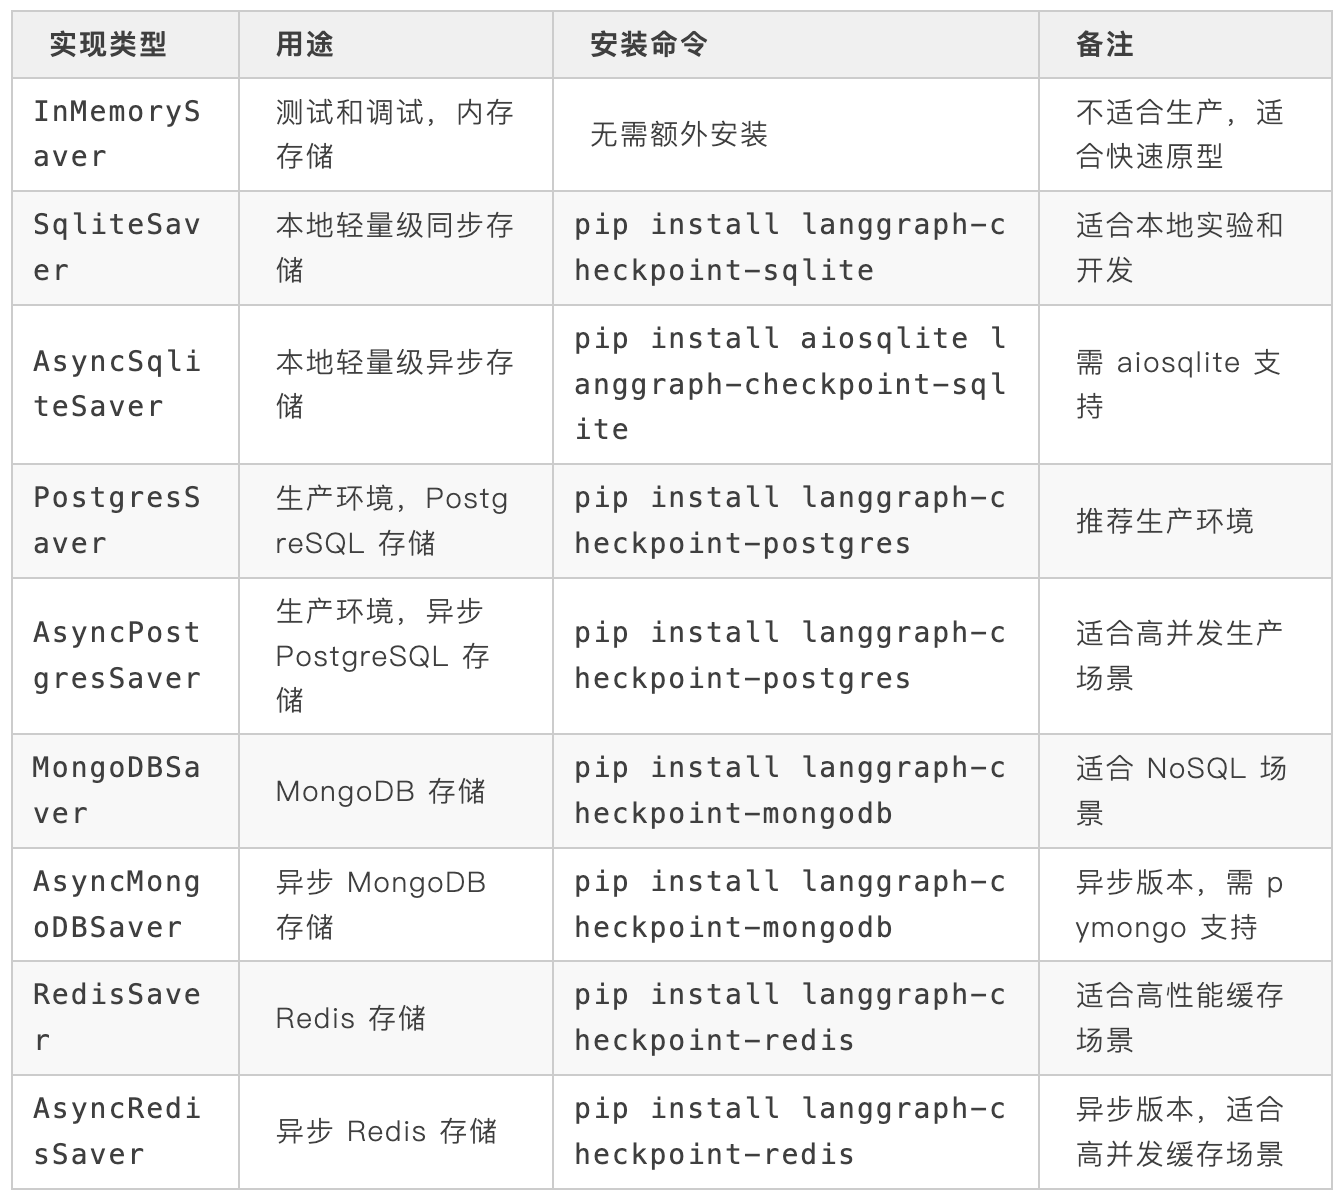

## 3.2 动态路由：Command 的用法
Command 对象允许节点向 LangGraph 执行器下达更精确的指令，最强大的功能就是动态路由。

Command(goto="..."): 动态覆盖图的路由它允许一个节点在运行时动态决定下一步去往哪个节点，从而覆盖预定义的静态图结构。add_edge 定义了固定的流程，而 goto 提供了基于运行时逻辑的灵活跳转能力。

**代码示例：构建一个带“质量审核”的动态跳转图**

我们构建一个流程：生成内容 -> 验证内容。验证节点将使用 goto 动态决定是直接结束，还是强制跳转到一个我们并未在图中显式连接的“人工审核”节点。

In [10]:
class GenerationState(TypedDict):
    messages: list
    generation: str

def generator_node(state:GenerationState):
    print(">>> 正在执行: generator_node")
    return{"generation":"这是一个初步生成的答案。"}

def validator_node(state:GenerationState):
    print(">>> 正在执行: validator_node")
    quality_score = random.random()
    print(f"答案质量分: {quality_score:.2f}")
    if quality_score >0.7:
        print("--- 决策: 质量合格，直接结束 ---")
        return Command(goto=END)
    else:
        print("--- 决策: 质量不合格，强制跳转到人工审核 ---")
        return Command(goto="human_review")

def human_review_node(state:GenerationState):
    print(">>> 正在执行: human_review_node (需要人工介入！)")
    return Command(update={"generation": state['generation']+" [经过人工优化]"})

# 构建图，我们故意不画 validator 到 human_review 的边
graph_dynamic =StateGraph(GenerationState)
graph_dynamic.add_node("generator", generator_node)
graph_dynamic.add_node("validator", validator_node)
graph_dynamic.add_node("human_review", human_review_node)
graph_dynamic.set_entry_point("generator")
graph_dynamic.add_edge("generator","validator")
graph_dynamic.add_edge("human_review","validator")# 审核后再次验证

app_dynamic = graph_dynamic.compile()

# 多次运行，会看到它有时直接结束，有时会进入 human_review
print("\n--- 运行动态跳转图 ---")
result = app_dynamic.invoke({"messages":[]})
print(result['generation'])


--- 运行动态跳转图 ---
>>> 正在执行: generator_node
>>> 正在执行: validator_node
答案质量分: 0.07
--- 决策: 质量不合格，强制跳转到人工审核 ---
>>> 正在执行: human_review_node (需要人工介入！)
>>> 正在执行: validator_node
答案质量分: 0.87
--- 决策: 质量合格，直接结束 ---
这是一个初步生成的答案。 [经过人工优化]


# 第四部分: 构建具备动态修正能力的研究助手
现在，我们将所有知识点整合起来：使用核心 stream_mode 来观测数据，并利用高级控制流（中断和动态路由）来构建一个更智能的 Agent。

**状态与节点定义**

In [11]:
from functools import partial

def add_messages(left: list[BaseMessage], right: list[BaseMessage],k:int=10)-> list[BaseMessage]:
    """将新消息列表追加到旧消息列表中"""
    full_list = left + right
    return full_list[-k:]

class ResearchState(TypedDict):
    messages:Annotated[list[BaseMessage],partial(add_messages, k=10)]
    search_results: list |None
    draft_report: str |None

async def generate_draft_node(state:ResearchState):
  """根据搜索结果生成报告初稿"""
  print("--- Executing node: generate_draft_node (AI正在撰写初稿...) ---")
  prompt = f"根据以下搜索结果，为用户的最后一个问题生成一份详细的报告初稿: {state['search_results']}"
  messages = state["messages"]+[("user", prompt)]
  response = await llm.ainvoke(messages)
  return{"draft_report": response.content}

def human_review_node(state:ResearchState):
    """人类审核节点 - 这个节点本身不执行逻辑，仅作为中断点"""
    print("--- Reached node: human_review_node (等待人类审核...) ---")
    return{}

def finalize_report_node(state:ResearchState):
    """根据（可能被修改过的）初稿生成最终消息"""
    print("--- Executing node: finalize_report_node (生成最终报告...) ---")
    reviewed_report = state["draft_report"]
    final_message =AIMessage(content=f"这是根据您的审核生成的最终报告：\n\n{reviewed_report}")
    return{"messages":[final_message]}

def quality_check_node(state:ResearchState):
    """    检查搜索结果的质量，并使用goto动态决定下一步。    """
    print("--- Executing node: quality_check_node ---")
    writer = get_stream_writer()
    writer({"status":"正在评估搜索结果质量...","type":"quality_check_node"})
    search_results = state.get("search_results")
    if not search_results or len(search_results) < 2:
        print("--- 决策: 搜索结果不足，中断并请求用户澄清 ---")
        return Command(goto="clarify_with_user_node")
    else:
        print("--- 决策: 搜索结果充足，跳转至报告生成 ---")
        return Command(goto="generate_draft_node")

def clarify_with_user_node(state:ResearchState):
    """生成需要用户澄清的提示消息"""
    clarify_msg =AIMessage(content="搜索结果不足，请提供更具体的问题或补充信息。")
    return{"messages":[clarify_msg]}

def agent_node(state:ResearchState):
    """思考节点：调用 LLM 决定下一步行动"""
    response = llm.bind_tools(tools).invoke(state['messages'])
    return{"messages":[response]}

def tool_executor(state:ResearchState):
    """执行工具并提取结果到 search_results"""
    tool_node =ToolNode(tools=tools)
    tool_output = tool_node.invoke(state)
    tool_results =[]
    for msg in tool_output["messages"]:
        if isinstance(msg,ToolMessage):
            import json
            tool_results.append(json.loads(msg.content))
            return{
                # "messages": tool_output["messages"],
                "search_results": tool_results
            }

def router(state:ResearchState)-> str:
    """路由：判断下一步是调用工具、直接结束还是进入质量检查"""
    last_message = state['messages'][-1]
    if hasattr(last_message,'tool_calls')and last_message.tool_calls:
        return"tool_node"
    else:
        return"END"

**构建并编译终极版图**

In [12]:
final_graph_builder =StateGraph(ResearchState)

final_graph_builder.add_node("agent_node", agent_node)
final_graph_builder.add_node("tool_node", tool_executor)
final_graph_builder.add_node("quality_check_node", quality_check_node)
final_graph_builder.add_node("clarify_with_user_node", clarify_with_user_node)

final_graph_builder.add_node("generate_draft_node", generate_draft_node)
final_graph_builder.add_node("human_review_node", human_review_node)
final_graph_builder.add_node("finalize_report_node", finalize_report_node)

final_graph_builder.add_edge("generate_draft_node","human_review_node")
final_graph_builder.add_edge("human_review_node","finalize_report_node")
final_graph_builder.add_edge("finalize_report_node",END)

final_graph_builder.set_entry_point("agent_node")

final_graph_builder.add_conditional_edges(
    "agent_node",
    router,
    {
        "tool_node":"tool_node",
        "END":END
    }
)

final_graph_builder.add_edge("tool_node","quality_check_node")
final_graph_builder.add_edge("clarify_with_user_node",END)
final_checkpointer =MemorySaver()
app = final_graph_builder.compile(
    checkpointer=final_checkpointer,
    interrupt_before=["human_review_node","clarify_with_user_node"],
)

**运行与解读**

In [14]:
async def run_collaborative_session():
    config ={"configurable":{"thread_id":"collab-thread-2"}}
    inputs ={"messages":[HumanMessage(content="对比一下LangGraph和传统的LangChain Agent在实现复杂工作流时的优劣势")]}

    print("--- [Session Start] ---")
    # 1. 启动图，它将运行直到第一个中断点
    async for output in app.astream(inputs, config=config):
        for key, value in output.items():
            print(f"Node '{key}' output: {value}")

    # 2. 检查中断状态
    current_state = await app.aget_state(config)

    # 检查是否在 human_review_node 中断
    if "human_review_node" in current_state.next:
        print("\n--- [Graph Interrupted for Human Review] ---")

        # 3. 从状态中提取生成的初稿
        draft_report = current_state.values.get("draft_report")

        print("\nAI 生成的报告初稿：")
        print("--------------------")
        print(draft_report)
        print("--------------------")

        # 4. 模拟用户在前端页面进行修改
        print("\n请在下方确认或修改报告内容。如果无需修改，直接按回车。")
        user_feedback = input("您的修改版本: ")

        # 如果用户没有输入，则使用原始初稿
        if not user_feedback.strip():
            final_draft = draft_report
            print("--- 用户已确认，使用原始初稿继续 ---")
        else:
            final_draft = user_feedback
        print("--- 用户已提交修改，使用新版本继续 ---")

        resume_inputs ={"draft_report": final_draft}

        print("\n--- [Session Resumed] ---")
        async for output in app.astream(resume_inputs, config=config):
            for key, value in output.items():
                print(f"Node '{key}' output: {value}")

    # 6. 获取并打印最终结果
    final_state = await app.aget_state(config)
    if not final_state.next:
        final_message = final_state.values["messages"][-1]
        print(final_message.content)

if __name__ =="__main__":
    await run_collaborative_session()

--- [Session Start] ---
Node 'agent_node' output: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_edaarRUwJ9gBLvTGpq6VVW3j', 'function': {'arguments': '{"query": "LangGraph advantages and disadvantages for complex workflows"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_D96EMKN0In2vIRsV7yUuqpaA', 'function': {'arguments': '{"query": "traditional LangChain Agent advantages and disadvantages for complex workflows"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 1290, 'total_tokens': 1354, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVfFR7vyFovIYYzYsAcofZnEyxr2X', 'service_tier': 'default', 'fi

# 总结
在本次教程中，我们系统性地学习了 LangGraph 的流式处理与高级控制机制：
- 掌握了 astream 的四种核心模式，实现了从状态快照到实时消息的精确数据流。
- 通过中断与恢复机制，为 Agent 工作流加入了关键的“人工审批”环节。
- 学会使用 Command 和 goto 实现动态路由，让 Agent 决策更灵活。
- 最终，我们将所有技术点融合，构建了一个功能完整、可观测的协作式 Agent。

至此，你已经具备了构建高级 Agent 所需的流式处理与流程控制的全部核心技术。